In [1]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from pathlib import Path
from tensorflow.keras.utils import image_dataset_from_directory
import seaborn as sns

2024-11-05 22:46:02.482189: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 22:46:05.061187: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 22:46:10.900760: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 22:46:10.906894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm

In [9]:
#directories for train, validation and test images
train_directory = Path('train_another') # the training data; 5000 images of each class(damage/no damage)
validation_directory = Path('validation_another') #the validation data; 1000 images of each class(damage/no damage)
unbalanced_test_directory = Path('test_another') # 8000/1000 images of damaged/undamaged classes
balanced_test_directory = Path('test') # the balanced test data; 1000 images of each class(damage/no damage)

In [10]:
#Inialising empty lists for storing both of the damage and no_damage folders
labels_train,images_train,labels_test_another,images_test_another,labels_test,images_test = [],[],[],[],[],[]

for i in ['damage','no_damage']: 
    files_train = os.listdir(f'train_another/{i}')
    files_test_another =  os.listdir(f'test_another/{i}')
    files_test =  os.listdir(f'test/{i}')
    images_train.append(files_train)
    images_test_another.append(files_test_another)
    images_test.append(files_test)

    for l in range(len(files_train)):
        labels_train.append(i)
    for l in range(len(files_test)):
        labels_test_another.append(i)
    for l in range(len(files_test_another)):
        labels_test.append(i)
    
print("Number of items in the training set : {}".format(len(labels_train)))
    
print("Number of items in the test_another dataset : {}".format(len(labels_test_another)))
    
print("Number of items in the test dataset : {}".format(len(labels_test)))

Number of items in the training set : 10000
Number of items in the test_another dataset : 2000
Number of items in the test dataset : 9000


In [5]:
#Defining an instance of the LabelEncoder Class
label_en = LabelEncoder()
#Using label_en to transform the list
labels_all = [0]*3
labels_all[0] = label_en.fit_transform(labels_train)
labels_all[1] = label_en.transform(labels_test_another)
labels_all[2] = label_en.transform(labels_test)


In [6]:
print(labels_all[1])

[0 0 0 ... 1 1 1]


/tmp/ipykernel_15950/1908126580.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(classes)
/tmp/ipykernel_15950/1908126580.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(classes)
/tmp/ipykernel_15950/1908126580.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(classes)


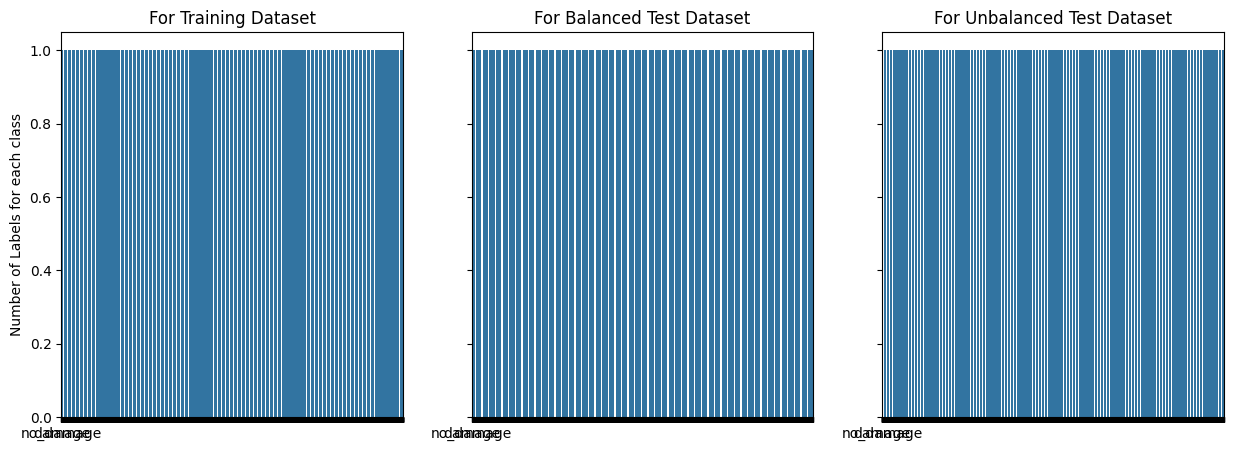

In [7]:
fig,ax = plt.subplots(1,3,figsize = (15,5),sharey = True)
classes = ['damage','no_damage']
sns.countplot(labels_all[0],ax = ax[0])
ax[0].set_title('For Training Dataset')
ax[0].set_xticklabels(classes)
ax[0].set_ylabel('Number of Labels for each class')
sns.countplot(labels_all[1],ax = ax[1])
ax[1].set_title('For Balanced Test Dataset')
ax[1].set_ylabel('Number of Labels for each class')
ax[1].set_xticklabels(classes)
sns.countplot(labels_all[2],ax = ax[2])
ax[2].set_title('For Unbalanced Test Dataset')
ax[2].set_ylabel('Number of Labels for each class')
ax[2].set_xticklabels(classes)
plt.show()

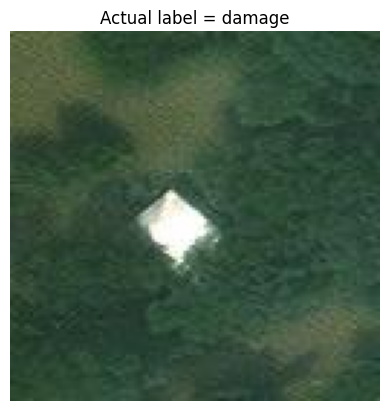

In [8]:
#quick image display with PIL
img1 = Image.open('train_another/damage/-93.55964_30.895018.jpeg') #train_damaged
plt.imshow(img1)
plt.title(f'Actual label = {labels_train[0]}')
plt.axis('off')
plt.show()

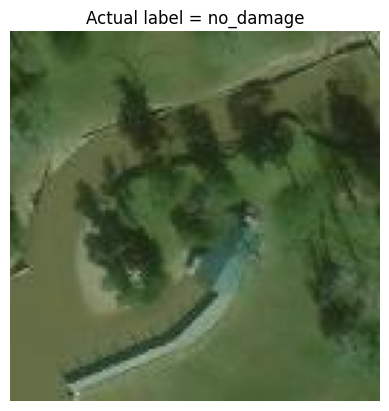

In [9]:
img2 = Image.open('train_another/no_damage/-95.061275_29.831535.jpeg') #train_undamaged
plt.imshow(img2)
plt.title(f'Actual label = {labels_train[5000]}')
plt.axis('off')
plt.show()

Our NumPy array has the shape: (128, 128, 3)


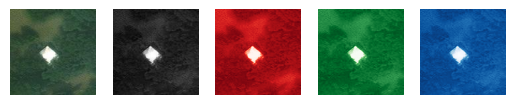

In [10]:
# Turn our image object into a NumPy array
img_data = np.array(img1)

# get the shape of the resulting array
img_data_shape = img_data.shape

print("Our NumPy array has the shape: {}".format(img_data_shape))

# plot the data with `imshow` 
fig,ax = plt.subplots(1,5)

ax[0].imshow(img_data)
ax[0].axis('off')
# grayscale image
ax[1].imshow(img_data[:,:,2], cmap='gray')
ax[1].axis('off')
# plot the red channel
ax[2].imshow(img_data[:,:,0], cmap=plt.cm.Reds_r)
ax[2].axis('off')
# plot the green channel
ax[3].imshow(img_data[:,:,1], cmap=plt.cm.Greens_r)
ax[3].axis('off')

# plot the blue channel
ax[4].imshow(img_data[:,:,2], cmap=plt.cm.Blues_r)
ax[4].axis('off')

plt.show()

In [11]:
train_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True,# horizontal flip
        rescale=1/255.0, #re-scaling
        brightness_range=[0.2,1.2]) # brightness)
validation_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        rescale=1/255.0, #re-scaling
        brightness_range=[0.2,1.2]) # brightness)
test_unbalanced_gen =  ImageDataGenerator()
test_balanced_gen =  ImageDataGenerator()

In [12]:
train_data = train_gen.flow_from_directory(
    directory = train_directory,
    target_size = (128,128),
    class_mode = 'binary',
    shuffle = True,
    batch_size=100)

val_data = validation_gen.flow_from_directory(
    directory = validation_directory,
    target_size = (128,128),
    class_mode = 'binary',
    shuffle = True,
    batch_size=100)
unbalanced_data = test_unbalanced_gen.flow_from_directory(directory =unbalanced_test_directory,
                                                          target_size = (128,128),
                                                          class_mode = 'binary',
                                                          shuffle = True,
                                                          batch_size=100)
balanced_data = test_balanced_gen.flow_from_directory(directory = balanced_test_directory,
                                                      target_size = (128,128),
                                                      class_mode = 'binary',
                                                      shuffle = True,
                                                      batch_size=100)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


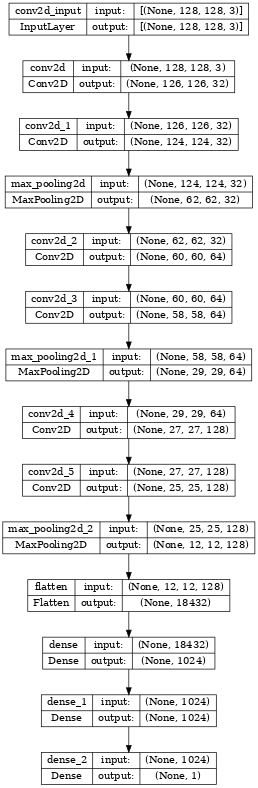

In [13]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout

# Initialize a sequential model
model = Sequential(name="Base_Model")


model.add(Conv2D(32,kernel_size =(3, 3), activation='relu',input_shape=(128,128,3)))
model.add(Conv2D(32,kernel_size =(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1024,activation='relu'))
model.add(Dense(1024,activation='relu'))

model.add(Dense(1,activation = 'sigmoid'))
tensorflow.keras.utils.plot_model(model, "base_model.png", show_shapes=True,dpi =50)

In [14]:
# Compiling the model
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history_1 = model.fit(train_data,validation_data=val_data,epochs=10)

Epoch 1/10
100/100 [==============================] - 367s 4s/step - loss: 0.5860 - accuracy: 0.6883 - val_loss: 0.4916 - val_accuracy: 0.8170
Epoch 2/10
100/100 [==============================] - 365s 4s/step - loss: 0.4319 - accuracy: 0.8256 - val_loss: 0.3665 - val_accuracy: 0.8600
Epoch 3/10
100/100 [==============================] - 253s 3s/step - loss: 0.3165 - accuracy: 0.8763 - val_loss: 0.2569 - val_accuracy: 0.8935
Epoch 4/10
100/100 [==============================] - 240s 2s/step - loss: 0.2509 - accuracy: 0.8996 - val_loss: 0.2505 - val_accuracy: 0.9025
Epoch 5/10
100/100 [==============================] - 245s 2s/step - loss: 0.2169 - accuracy: 0.9117 - val_loss: 0.1833 - val_accuracy: 0.9300
Epoch 6/10
100/100 [==============================] - 242s 2s/step - loss: 0.2182 - accuracy: 0.9112 - val_loss: 0.1830 - val_accuracy: 0.9295
Epoch 7/10
100/100 [==============================] - 239s 2s/step - loss: 0.1994 - accuracy: 0.9199 - val_loss: 0.2369 - val_accuracy: 0.9085

In [16]:
test_unbalanced_acc_1 = model.evaluate(unbalanced_data,verbose=0)
print('Test Accuracy of Specified Base Model on Unbalanced Test Dataset : {}'.format(test_unbalanced_acc_1[1] ))
test_balanced_acc_1= model.evaluate(balanced_data,verbose =0)
print('Test Accuracy of Specified Base Model on Balanced Test Dataset : {}'.format(test_balanced_acc_1[1] ))

Test Accuracy of Specified Base Model on Unbalanced Test Dataset : 0.7803333401679993
Test Accuracy of Specified Base Model on Balanced Test Dataset : 0.8335000276565552


In [18]:
val_img1 = Image.open('validation_another/damage/-93.558326_30.895248.jpeg')
val_img2 = Image.open('validation_another/damage/-93.563851_30.894492.jpeg')
val_img3 = Image.open('validation_another/no_damage/-95.061894_30.007746.jpeg')
val_img4 = Image.open('validation_another/no_damage/-95.062123_30.056714000000003.jpeg')
val_img_labels = [0,0,1,1]
val_imgs = [val_img1,val_img2,val_img3,val_img4]

In [19]:
val_img_data = []
for img_data in val_imgs:
    data = np.array(img_data)
    data = data/255.0
    data = np.expand_dims(data,axis=0)
    #print(data.shape)
    val_img_data.append(data)

1/1 [==============================] - 1s 865ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


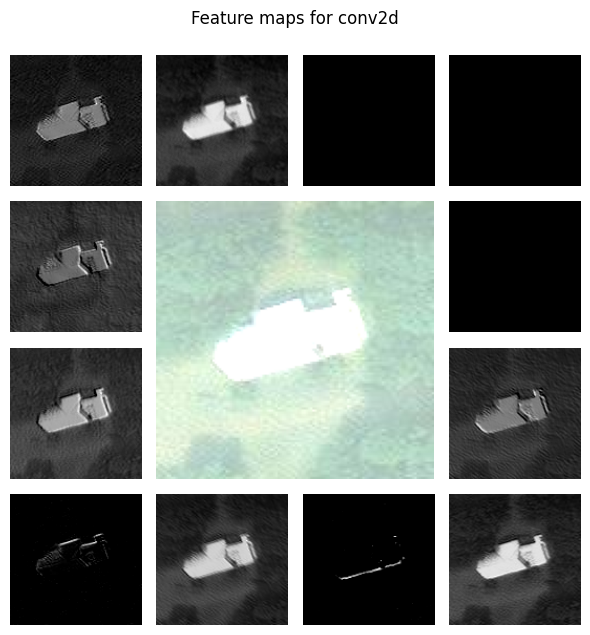

In [20]:
#Helper function used to plot the activation maps
def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    axbig.imshow(img.squeeze()+0.5)
    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i], cmap='gray')
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Feature maps for {layer_names[0]}',y=1.05);

first_conv_layer_output = model.layers[0].output
activation_model = Model(inputs=model.input,outputs=first_conv_layer_output)
activations = activation_model.predict(val_img_data[0])
plot_featuremaps(val_img_data[0],activations,[model.layers[0].name])

In [21]:
#Defining score function for saliency maps and GradCAM heatmap
def score_function(index):
    if (index==0 or index==1):
        score = BinaryScore(0.0)
    else:
        score = BinaryScore(1.0)
    return score

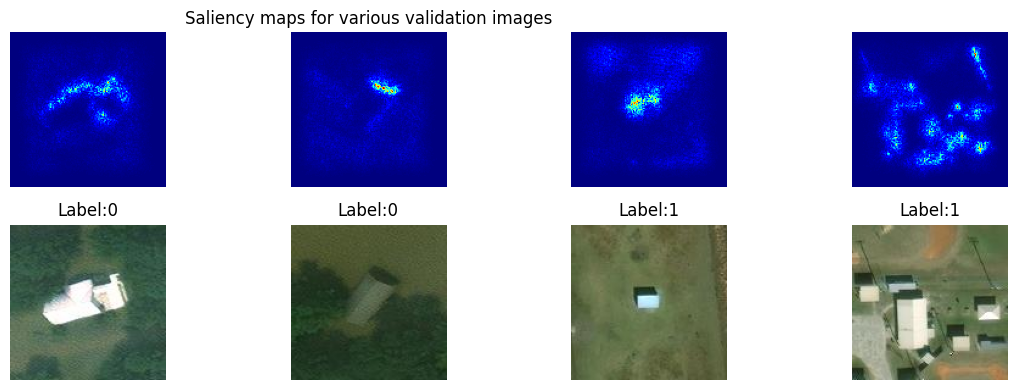

In [22]:
fig,ax = plt.subplots(2,4,figsize=(12, 4))

for i in range(4):
    saliency_model = Saliency(model,model_modifier=ReplaceToLinear(),clone=True)
    saliency_map = saliency_model(score_function(i),val_img_data[i])
    
    ax[1,i].imshow(val_imgs[i])
    ax[1,i].set_title(f'Label:{val_img_labels[i]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(saliency_map[0], cmap='jet')
    ax[0,1].set_title('Saliency maps for various validation images')
    ax[0,i].axis('off')

plt.tight_layout()
plt.show()

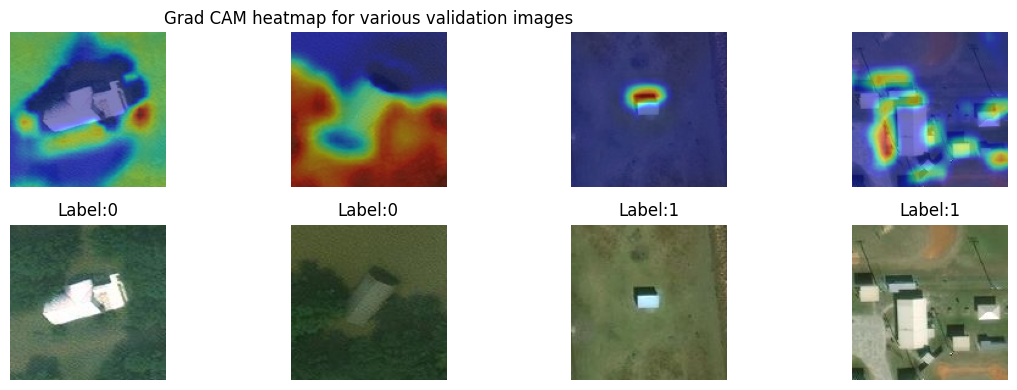

In [23]:
fig,ax = plt.subplots(2,4,figsize=(12, 4))

for i in range(4):
    gradcam = Gradcam(model,model_modifier=ReplaceToLinear(),clone=True)
    cam = gradcam(score_function(i),val_img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(val_imgs[i])
    ax[1,i].set_title(f'Label:{val_img_labels[i]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(val_img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    ax[0,1].set_title('Grad CAM heatmap for various validation images')
    ax[0,i].axis('off')

plt.tight_layout()
plt.show()

In [24]:
# Save the entire model as a SavedModel format
model.save("disaster_base_model")


INFO:tensorflow:Assets written to: disaster_base_model/assets


INFO:tensorflow:Assets written to: disaster_base_model/assets


In [2]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image and resize it to the same dimensions as the training data (e.g., 128x128)
img_path = '/home/abhay/my_projects/disaster_management/fir.jpeg'
img = image.load_img(img_path, target_size=(128, 128))

# Convert the image to an array
img_array = image.img_to_array(img)

# Normalize the pixel values (assuming your training images were normalized by dividing by 255.0)
img_array = img_array / 255.0

# Add an extra dimension to make it a batch (1, 128, 128, 3)
img_array = np.expand_dims(img_array, axis=0)


In [3]:
# Get the prediction from the model
prediction = model.predict(img_array)

# Print the prediction
print("Prediction (Probability):", prediction[0][0])

# Interpret the prediction
if prediction[0][0] > 0.5:
    print("Predicted Class: No Damage")
else:
    print("Predicted Class: Damage")


1/1 [==============================] - 1s 792ms/step
Prediction (Probability): 0.004016231
Predicted Class: Damage


In [1]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("disaster_base_model")


: 

In [ ]:
# List of image paths
image_paths = ['path/to/image1.jpeg', 'path/to/image2.jpeg', 'path/to/image3.jpeg']

# Preprocess all images and add to a batch
batch = []
for img_path in image_paths:
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    batch.append(img_array)

# Stack all images into a single numpy array
batch_array = np.vstack(batch)

# Get predictions for the batch
predictions = model.predict(batch_array)

# Print the predictions
for i, pred in enumerate(predictions):
    print(f"Image {i+1}: Prediction Probability = {pred[0]}")
    print("Predicted Class:", "No Damage" if pred[0] > 0.5 else "Damage")
